## MU-SM SSK

In [49]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import datetime
import time

In [56]:
time_start = time.time()

# set variables used for saving the data
name = 'MU-SM'
date_object = datetime.datetime.utcnow() # utc time is used

# simulation parameters
N_t = 16 # number of transmit antennas per user
N_u = 4 # number of users

#SNR_dB_list = np.array([0, 2.5, 5, 7.5, 10, 15, 20, 25, 30, 40, 50])
#errors_required_list = np.array([100000, 100000, 10000, 10000, 1000, 1000, 1000, 100, 100, 10, 10])

SNR_dB_list = np.array([0, 5, 10, 20, 30, 40])
errors_required_list = np.array([10000, 10000, 1000, 100, 100, 10])

simulation_points = len(SNR_dB_list)
iterator = np.arange(simulation_points)

# initialization of objects containing the results
BER_list = np.ones(simulation_points)

for index in iterator:

    time_start_round = time.time() # taking time for measuring
    
    SNR = 10**(SNR_dB_list[index]/10)
    errors_required = errors_required_list[index]
    
    sigma_noise = 1/np.sqrt(SNR)
    sigma_fading = 1 # Rayleigh fading is normalized
    E_m = 1 # energy is set to one for the beginnig
    E_sqrt = np.sqrt(E_m) # in the formulas, most of the time, the square root of the energy is needed

    bit_error = 0
    transmission_count = 0

    while bit_error < errors_required:
        
        H_eff = np.zeros((N_u,N_u), dtype=complex) #initialize channel matrix
        x = 1 # modulated signal is 1 for SSK
        modulation_sceme = 'SSK' # adjust output in csv file according to modulation sceme

        i = 0
        while i < N_u:
            j = 0
            while j < N_u:
                H_eff[i,j] = (np.random.normal(0, sigma_fading) + 1j*np.random.normal(0, sigma_fading)) * x
                j += 1
            i += 1

        # calculating the precoder
        H_eff_inv = np.linalg.inv(H_eff)
        H_eff_diag = np.diag(H_eff)
        H_eff_diag = H_eff_diag.reshape(N_u,1)
        P = H_eff_inv.dot(H_eff_diag)

        # normalizing the precoder
        beta = 1 # set beta to one for the beginning

        # calculating the preprocessed data
        H_req = H_eff.dot(P)

        # creating noise
        n = np.ones(N_u, dtype=complex)
        i = 0
        while i < N_u:
            n[i] = np.random.normal(0, sigma_noise) + 1j * np.random.normal(0, sigma_noise)
            i += 1
        n = n.reshape(N_u,1)

        # calculating the received symbol
        Y = H_req.dot(E_sqrt * beta) + n


        # note: without loss of generality the BER is simulated only for one user
        
        # creating the channels to the remaining antennas of the block considered user
        H_block_channels = np.ones(N_t, dtype=complex)
        j = 0
        while j < N_t - 1:
            H_block_channels[j] = np.random.normal(0, sigma_fading) + 1j*np.random.normal(0, sigma_fading)
            j += 1
        H_block_channels[j] = H_eff[1,1] # add the used channel to the end of the array

        # maximum likelihood estimator
        differences = np.ones(N_t, dtype=complex)
        i = 0
        while i < N_t: # find the differences to all possible receive paths (antennas)
            differences[i] = Y[1] - E_sqrt * beta * H_block_channels[i] * x 
            i += 1

        # choose the antenna with the smallest difference to the received symbol
        min_index = np.argpartition(np.absolute(differences), 0) # searched index is on 0th position of returned array

        # bit error occured, when estimated antenna is not used antenna 
        if min_index[0] != N_t - 1:
            bit_error += 1
        transmission_count += 1

        if transmission_count > 10000000:
            break

    BER = bit_error / transmission_count
    BER_list[index] = BER
    
    time_end_round = time.time()
    time_round = time_end_round - time_start_round

    print(str(transmission_count) + ', time needed for simulation point: ' + str(time_round))
print(BER_list)
time_end = time.time()
time_overall = time_end - time_start
print('Overall time needed: %f' % time_overall)

13369, time needed for simulation point: 3.703967332839966
16967, time needed for simulation point: 5.140794992446899
2645, time needed for simulation point: 0.7258474826812744
1477, time needed for simulation point: 0.40864062309265137
12699, time needed for simulation point: 3.583308458328247
9666, time needed for simulation point: 2.649686574935913
[0.7479991  0.58937938 0.37807183 0.06770481 0.00787464 0.00103455]
Overall time needed: 16.214918


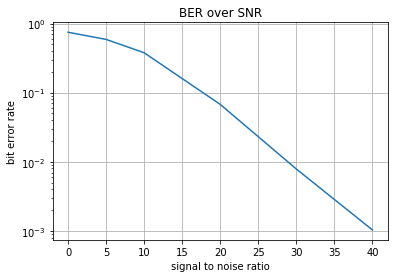

In [57]:
fig, ax = plt.subplots()

ax.plot(SNR_dB_list, BER_list)
ax.set_yscale('log')
ax.set_xlabel('signal to noise ratio')
ax.set_ylabel('bit error rate')
ax.set_title('BER over SNR')
ax.grid(True)

## save csv file

In [58]:
date = date_object.strftime('%Y-%m-%dT%H:%MZ') # depiction of date and time after ISO 8601 without seconds
file_name = './results/' + name + '_' + date + '.csv'

parameter_string_1  = 'Number of users N_t = \t\t\t%i\n' % N_u
parameter_string_1a = 'Number of antennas (per user) N_u = \t\t%i\n' % N_t
parameter_string_2  = 'Simulated SNRs in dB: \t\t\t' + str(SNR_dB_list) + '\n'
parameter_string_3  = 'Required errors for the respective SNRs: \t' + str(errors_required_list) + '\n'
parameter_string_4  = 'Modulation sceme: \t\t\t\t%s' % modulation_sceme + '\n'
parameter_string_5  = 'Name of simulation: \t\t\t\t' + name + '\n'
date_string         = 'Date and Time: \t\t\t\t' + date_object.strftime('%Y-%m-%dT%H:%M:%SZ') + '\n'
time_string         = 'Overall time needed: \t\t\t\t%f\n' % time_overall
header =  parameter_string_5 + parameter_string_1  + parameter_string_1a + parameter_string_2 + parameter_string_3 + parameter_string_4 + date_string + time_string + '\n'

np.savetxt(file_name, np.c_[SNR_dB_list, BER_list], header=header, delimiter=',')